# Fine-tune Network on SnakeCLEF 2021 Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, metrics, training, data, loss_functions
from src.utils import nb_setup
from src.dev import experiments as exp

DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [2]:
# create training 
config = exp.create_config(
    data='clef2021',
    model='efficientnet_b0',
    loss='ce',
    opt='sgd',
    no_epochs=30,
    batch_size=64,
    total_batch_size=64,
    learning_rate=0.01,
    weight='none',
    dataset='mini_cleaned',
    scheduler='reduce_lr_on_plateau',
    # note=''
)

# include configuration from model
_model_config = models.get_model(config.model, pretrained=False).pretrained_config
config.update(_model_config)

# save config file
config.save(DATA_DIR + config.specs_name)

# create loss, optimizer and scheduler functions
loss_fn = loss_functions.LOSSES[config.loss]
weight_fn = loss_functions.WEIGHTING[config.weight]
opt_fn = training.OPTIMIZERS[config.opt]
sched_fn = training.SCHEDULERS[config.scheduler]

DATASETS = {
    'full': 'SnakeCLEF2021_train_metadata_PROD.csv',
    'mini': 'SnakeCLEF2021_train_metadata_mini_PROD.csv',
    'full_cleaned': 'SnakeCLEF2021_train_metadata_cleaned.csv',
    'mini_cleaned': 'SnakeCLEF2021_train_metadata_mini.csv',
    'mini_cutoff_1000': 'SnakeCLEF2021_train_metadata_mini_cutoff_1000.csv',
    'mini_cutoff_500': 'SnakeCLEF2021_train_metadata_mini_cutoff_500.csv',
    'mini_cutoff_100': 'SnakeCLEF2021_train_metadata_mini_cutoff_100.csv'
}

print(config)

Config(
* model_name: clef2021_efficientnet_b0_ce_11-10-2021_11-09-53
* history_file: clef2021_efficientnet_b0_ce_11-10-2021_11-09-53.csv
* specs_name: clef2021_efficientnet_b0_ce_11-10-2021_11-09-53.json
* model: efficientnet_b0
* loss: ce
* opt: sgd
* no_epochs: 30
* batch_size: 64
* total_batch_size: 64
* learning_rate: 0.01
* weight: none
* dataset: mini_cleaned
* scheduler: reduce_lr_on_plateau
* pretrained_checkpoint: tf_efficientnet_b0
* input_size: 224
* image_mean: (0.485, 0.456, 0.406)
* image_std: (0.229, 0.224, 0.225))


## Load the Data

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + DATASETS[config.dataset])
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')

classes = np.unique(train_df['binomial'])
no_classes = len(classes)
assert no_classes == len(np.unique(valid_df['binomial']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 770
Train set length: 70,440
Validation set length: 26,227


In [4]:
species = np.unique(train_df['binomial'])

# load country-species map, country-country LuT and rename countries
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)
country_weights = metrics.clean_country_map(country_map_df, species, missing_val=0)

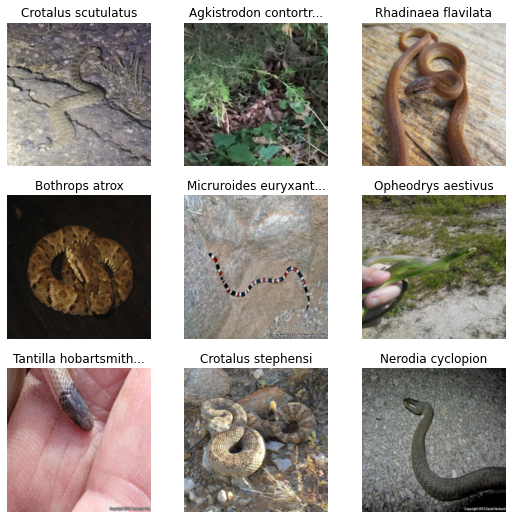

In [5]:
# create transforms
train_tfms, valid_tfms = data.get_transforms(
    size=config.input_size, mean=config.image_mean,
    std=config.image_std)

# create data loaders
trainloader = data.get_dataloader(
    train_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=train_tfms, labels=classes,
    batch_size=config.batch_size, shuffle=True, num_workers=4)
validloader = data.get_dataloader(
    valid_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms, labels=classes,
    batch_size=config.batch_size, shuffle=False, num_workers=4)

trainloader.dataset.show_items()

## Train the Model

In [6]:
# create model
model = models.get_model(config.model, no_classes, pretrained=True)
assert np.all([param.requires_grad for param in model.parameters()])

# create loss
freq = train_df['binomial'].value_counts()[trainloader.dataset.labels].values
weights = weight_fn(freq)
criterion = loss_fn(weight=torch.Tensor(weights).to(device) if weights is not None else None)

# create trainer
trainer = training.Trainer(
    model,
    trainloader,
    criterion,
    opt_fn,
    sched_fn,
    validloader=validloader,
    accumulation_steps=config.total_batch_size // config.batch_size,
    path=DATA_DIR,
    model_filename=config.model_name,
    history_filename=config.history_file,
    metrics=[metrics.CountryF1Score(country_weights)],
    device=device)

In [7]:
# train model
trainer.train(no_epochs=config.no_epochs, lr=config.learning_rate)

epoch,train_loss,valid_loss,accuracy,top_3,f1_score,country_f1_score,time
0,4.962754,3.217382,0.248103,0.459908,0.093558,0.102804,06:00
1,3.452570,2.588722,0.372898,0.623975,0.194578,0.240497,05:35
2,2.883384,2.265503,0.415450,0.642811,0.274205,0.296302,05:30
3,2.513923,1.908720,0.484081,0.746063,0.337577,0.314401,05:38
4,2.226283,1.992566,0.466656,0.710184,0.380098,0.336494,05:30
5,1.990265,1.798684,0.545468,0.769360,0.431021,0.437270,05:33
6,1.783485,1.880783,0.525184,0.706028,0.425537,0.426142,05:36
7,1.595752,1.560417,0.608838,0.786785,0.473509,0.464662,05:35
8,1.425360,1.670185,0.596027,0.738666,0.482657,0.451856,05:39
9,1.265064,1.520042,0.573302,0.804553,0.483977,0.462356,05:37


Epoch 1 - Save Checkpoint with Best F1 Score: 0.093558
Epoch 2 - Save Checkpoint with Best F1 Score: 0.194578
Epoch 3 - Save Checkpoint with Best F1 Score: 0.274205
Epoch 4 - Save Checkpoint with Best F1 Score: 0.337577
Epoch 5 - Save Checkpoint with Best F1 Score: 0.380098
Epoch 6 - Save Checkpoint with Best F1 Score: 0.431021
Epoch 8 - Save Checkpoint with Best F1 Score: 0.473509
Epoch 9 - Save Checkpoint with Best F1 Score: 0.482657
Epoch 10 - Save Checkpoint with Best F1 Score: 0.483977
Epoch 11 - Save Checkpoint with Best F1 Score: 0.502186
Epoch 12 - Save Checkpoint with Best F1 Score: 0.505778
Epoch    14: reducing learning rate of group 0 to 9.0000e-03.
Epoch 15 - Save Checkpoint with Best F1 Score: 0.530335
Epoch 16 - Save Checkpoint with Best F1 Score: 0.539323
Epoch    18: reducing learning rate of group 0 to 8.1000e-03.
Epoch    20: reducing learning rate of group 0 to 7.2900e-03.
Epoch 20 - Save Checkpoint with Best F1 Score: 0.540026
Epoch 21 - Save Checkpoint with Best F